In [1]:
import numpy as np
from util_functions import normalize, plot_agents, plot_mdp

# TestEnv for Repeated prisoner dillema
There are two states which represent the cooperation status at last state: `COOP` and `BETRAY`. Only if two agents both cooperate at last stage, then next state will be `COOP`, otherwise will be `BETRAY`. Note that the row's actions are for agent label in the table. The state will increase the utility of choosing that state action.

Specifically, at state `COOP`, the utility function for agents are:  
| agent 1 $\rightarrow$ | cooperate | betray |  | agent 2 $\rightarrow$ | cooperate | betray |
|---|---|---|---|---|---|---|
|cooperatre| 2+1 (3) | +4 | | cooperate | 2+1(3) | +4 |
|betray | -4+1(-3) | -2 | | betray | -4+1(-3) | -2 |

At state `BETRAY`, the utility function for agents are:
| agent 1 $\rightarrow$ | cooperate | betray | | agent 2 $\rightarrow$ | cooperate | betray | 
|---|---|---|---|---|---|---|
|cooperatre| +2 | 4+1(5) | | cooperate | +2 | 4+1(5) |
|betray | -4 | -2+1(-1) | | betray | -4 | -2+1(-1) | 

We denote each matrix as $U_C^{1}$, $U_C^{2}$ as utility matrix at state `COOP` for agent 1 and agent 2 respectively. And denote $U_B^{1}$, $U_B^{2}$ as utility matrix at state `BETRAY` for agent 1 and agent 2 respectively. 


In [2]:
utility_coop_a1 = np.array([ [3,4],[-3,-2] ])
utility_coop_a2 = np.array([ [3,4],[-3,-2] ])
utility_betray_a1 = np.array([ [2,5],[-4,-1] ])
utility_betray_a2 = np.array([ [2,5],[-4,-1] ])

To make the strategies of agents not pure strategies, we add entropy term. Assume we denote
$$a^i_C\in\Delta(\{cooperate, betray\})=:\Delta(2)$$
as the strategy agent $i$ take in state `COOP`, then we have: 
$$ u^1_C(a^1_C, a^2_C) = (a_C^2)^\top U_C^1 a^1_C - \lambda (a^1_C)^\top \log(a^1_C) + ([\theta^1_C,0])^\top a^1_C \\
u^2_C(a^1_C, a^2_C) = (a_C^1)^\top U_C^2 a^2_C - \lambda (a^2_C)^\top \log(a^2_C) + ([\theta^2_C,0])^\top a^2_C\\
u^1_B(a^1_B, a^2_B) = (a_B^2)^\top U_B^1 a^1_B - \lambda (a^1_B)^\top \log(a^1_B) + ([\theta^1_B,0])^\top a^1_B\\
u^2_B(a^1_B, a^2_B) = (a_B^1)^\top U_B^2 a^B_C - \lambda (a^2_B)^\top \log(a^2_B) + ([\theta^2_B,0])^\top a^2_B $$
where $\lambda$ is the temperature variable, and $\theta_C^1\in\mathbb{R}$ is the incentive provided to agent 1 for taking cooperate action, and other $\theta^2_C, \theta^1_B$ have corresponding meaning. Note that incentive will only apply to the 'cooperation' action, thus the incentive vector is $[\theta^1_C, 0]$, $[\theta^2_C, 0]$ at state `COOP`, and $[\theta^1_B, 0]$, $[\theta^1_B, 0]$ at state `BETRAY`. 

We assume that agents use mirror ascent to update their strategies to find the Nash equilirium, therefore we have: 
$$ 
\begin{align*}
u^1_{C,k+1} &\leftarrow \mathop{\argmax}_{a^1_C\in\Delta(2)} \left\{  \nabla_{a^1_C}u^1_C(a^1_{C,k}, a^2_{C,k})^\top (a^1_C-a^1_{C,k}) - \frac{1}{\alpha_k} D_{KL}(a^1_C, a^1_{C,k})  \right\}
\end{align*}
$$
and $\alpha_k$ is pre-defined step size and $D_{KL}(a^1_C, a^1_{C,k}):=(a^1_C)^\top \log(a^1_C / a^1_{C,k}) $. Under this setting, the update rule has closed-form solution by the first-order optimality condition of above optimization problem. 
$$
a^1_{C,k+1} \propto a^1_{C,k} * \exp(\alpha_k \nabla_{a^1_C}u^1_C(a^1_{C,k}, a^2_{C,k}))
$$
where $*$ is element-wise multiplication. Note that this make sense if we get rid of the entropy term, then the gradient for agent 1 is $(a_C^2)^\top U_C^1 + \theta_C^1$ which is exactly the utility of choosing each action. Therefore the gradient is actually the ‘marginal influence’ of actions for agent 1. （Note sure whether this is correct. ）

In [3]:
def update_strategies(s, a1, a2, i1, i2, lamda, alpha):
    """ Update strategies once """
    if s == 0:  # COOP
        u1 = utility_coop_a1
        u2 = utility_coop_a2
    elif s == 1:    # BETRAY
        u1 = utility_betray_a1
        u2 = utility_betray_a2
    
    # Calculate strategy before normalization
    a1_ = a1 * np.exp( alpha * (a2.T @ u1 + i1 - lamda * np.ones(2) - lamda * np.log(a1)) )
    a2_ = a2 * np.exp( alpha * (a1.T @ u2 + i2 - lamda * np.ones(2) - lamda * np.log(a2)) )

    # Normalize
    a1_normalized = normalize(a1_)
    a2_normalized = normalize(a2_)

    return a1_normalized, a2_normalized

For example, we can try with incentive begin both zero, and $\lambda$ be 0.1. The result could be calculated by a while loop.

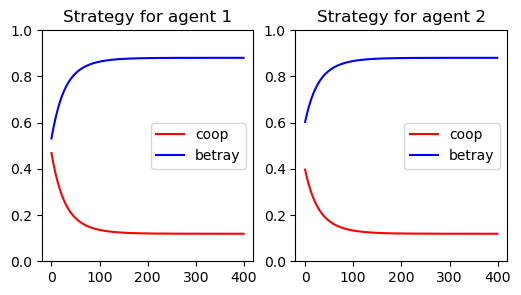

In [4]:
def find_ne(s, a1, a2, i1, i2, lamda, alpha, T):
    a1_C_traj = np.zeros([T, 2])
    a2_C_traj = np.zeros([T, 2])
    cnt = 0
    while cnt<T:
        a1_C_traj[cnt] = a1
        a2_C_traj[cnt] = a2
        if s==0:
            a1, a2 = update_strategies(0, a1, a2, i1, i2, lamda=lamda, alpha=alpha)
        else:
            a1, a2 = update_strategies(1, a1, a2, i1, i2, lamda=lamda, alpha=alpha)
        cnt += 1
    return a1_C_traj, a2_C_traj

T = 400
init_a1 = normalize( np.random.uniform(0,1,2) )
init_a2 = normalize( np.random.uniform(0,1,2) )
# init_a1 = np.array( [0.85, 0.15] )
# init_a2 = np.array( [0.2, 0.8] )
i1 = np.array([0,0])  # PLEASE change here the incentive
i2 = np.array([0,0])

# Calculate Nash equilibrium and plot the trajectory of strategies
a1_C_traj, a2_C_traj = find_ne(0, init_a1,init_a2,i1,i2,lamda=0.5,alpha=0.05,T=T)
plot_agents(T, a1_C_traj, a2_C_traj)

## MDP formulation
Now we can turn to the MDP setting. We need to sepcify transition probability and reward function. To simplify the notation, we denote $\mathbf{c}$ as action cooperate and $\mathbf{b}$ as aciton betray
The transition probability is rather easy, it is determined by agents' strategies: 
$$
\begin{align*}
P(\text{COOP|COOP}) &= a^1_C[\mathbf{c}] * a^2_C[\mathbf{c}] \\
P(\text{BETRAY|COOP}) &= a^1_C[\mathbf{c}] * a^2_C[\mathbf{b}] + a^1_C[\mathbf{b}] * a^2_C[\mathbf{c}] + a^1_C[\mathbf{b}] * a^2_C[\mathbf{b}]\\
P(\text{COOP|BETRAY}) &= a^1_B[\mathbf{c}] * a^2_B[\mathbf{c}] \\
P(\text{BETRAY|BETRAY}) &= a^1_B[\mathbf{c}] * a^2_B[\mathbf{b}] + a^1_B[\mathbf{b}] * a^2_B[\mathbf{c}] + a^1_B[\mathbf{b}] * a^2_B[\mathbf{b}]
\end{align*}
$$
We develope three modes of reward function. The first is easiest, second is harder and the third is impossible
$$
\begin{align*}
1 \qquad &R(\text{COOP}) = 1, &R(\text{BETRAY})&=0\\
2 \qquad &R(\text{COOP}) = (a^1_C[\mathbf{c}] + a^2_C[\mathbf{c}])*2, &R(\text{BETRAY}) &= a^1_B[\mathbf{b}]+a^2_B[\mathbf{b}]\\
3 \qquad &R(\text{COOP}) = (a^1_C[\mathbf{c}]-0.7)^2 + (a^2_C[\mathbf{c}]-0.8)^2 &R(\text{BETRAY}) &= (a^1_B[\mathbf{b}]-0.6)^2 + (a^2_B[\mathbf{b}]-0.6)^2
\end{align*}
$$
We can show in other files that the agents' strategies are actaully given by the mean of incentive. Therefore, by setting the probability of choosing actions, we can achieve bonuses in between.  

In [5]:
def get_P_vec(a1_s, a2_s):
    P = np.zeros(2)
    P[0] = a1_s[0] * a2_s[0]
    P[1] = 1-P[0]
    return P

def get_P_mat(a1, a2):
    P = np.zeros([2,2])
    P[0] = get_P_vec(a1[0], a2[0])  # COOP -> [COOP, BETRAY]
    P[1] = get_P_vec(a1[1], a2[1])  # BETRAY -> [COOP, BETRAY]
    return P

## Algorithm
We separate the proposed algorithm into two stage.  

In the first stage, we find the reward function and transition probability given pure incentive actions. We find the Nash equilibrium given pure incentive, and calculate according to $\bar{R}(s,\mathbf{a})$ and $\bar{P}(s'|s,\mathbf{a})$.  

In the second stage, we simultaneously update incentive policy and agents startegies. At each iteration, we use agents' current strategies to compute V-value function and calculate approximated policy gradient to update incentive policy.  

The pseudo-code can be summarized as follows:  

<div align=center><img src="./pseudo-code.png"></div>

In [6]:
# Possible incentive actions
# actions = np.array( [[[1,0], [1,0]],
#                      [[1,0], [-1,0]],
#                      [[-1,0], [1,0]],
#                      [[-1,0], [-1,0]]] ) * 6
# action[i][j][k]: action i; state j; agent k

actions = np.array( [[[0,0], [0,0]], 
                     [[1,0], [1,0]], 
                     [[2,0], [2,0]], 
                     [[3,0], [3,0]], 
                     [[4,0], [4,0]], 
                     [[5,0], [5,0]], 
                     [[6,0], [6,0]]] )


def get_RP(R, lamda=0.1, alpha=0.2, ):
    R_pre = np.zeros([2, actions.shape[0]]) # reward (s,a)
    P_pre = np.zeros([2, actions.shape[0], 2])  # (s,a) -> \Delta(2) i.e., [P(s'|s,a)]_{s'\in S}
    initial_a = np.ones(2) / 2.0
    for s in [0,1]:
        for idx, a in enumerate(actions):
            a1_traj, a2_traj = find_ne(s=s, a1=initial_a, a2=initial_a, i1=a[0], i2=a[1], lamda=lamda, alpha=alpha, T=50)
            a1 = a1_traj[-1]
            a2 = a2_traj[-1]
            R_pre[s, idx] = R(s, a1, a2)
            P_pre[s, idx] = get_P_vec(a1, a2)
    return R_pre, P_pre

Note that since we adopt reward type=0, that is $\mathbf{1}(s=$ `COOP` $)$, therefore the first line is 1 and second line is 0. Since the first line represent state action pair (`COOP`, $\cdot$) and second line represent (`BETRAY`, $\cdot$)  

Then we update agents' strategies and incentive policy simultaneously. Note that when updating incentive policy, we first calculate the V-value function based on current agents' strategies. 

## Result for reward_type=0
When reward type is 0, i.e.
$$
\begin{align}
\bar{R}_{\text{COOP}}(s,\mathbf{a}) :&= 1\\
\bar{R}_{\text{BETRAY}}(s,\mathbf{a}) :&= 0
\end{align}
$$  

, the policy should converge to action 0, which applies maximum bonus on the cooperate action for both agents.  

The reward calculated in the first stage is: 

In [7]:
lamda = 3

def R0(s, a1, a2):
    assert s==0 or s==1, "The input s is {}, which is neighter 0 nor 1".format(s)
    if s==0:
        reward = 1    # COOP
    elif s==1:
        reward = 0    # BETRAY
    return reward

R_pre, P_pre = get_RP(R0, lamda=lamda, alpha=0.5)
print("Immediate reward for reward_type=0 is\n {}".format(R_pre))

Immediate reward for reward_type=0 is
 [[1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]]


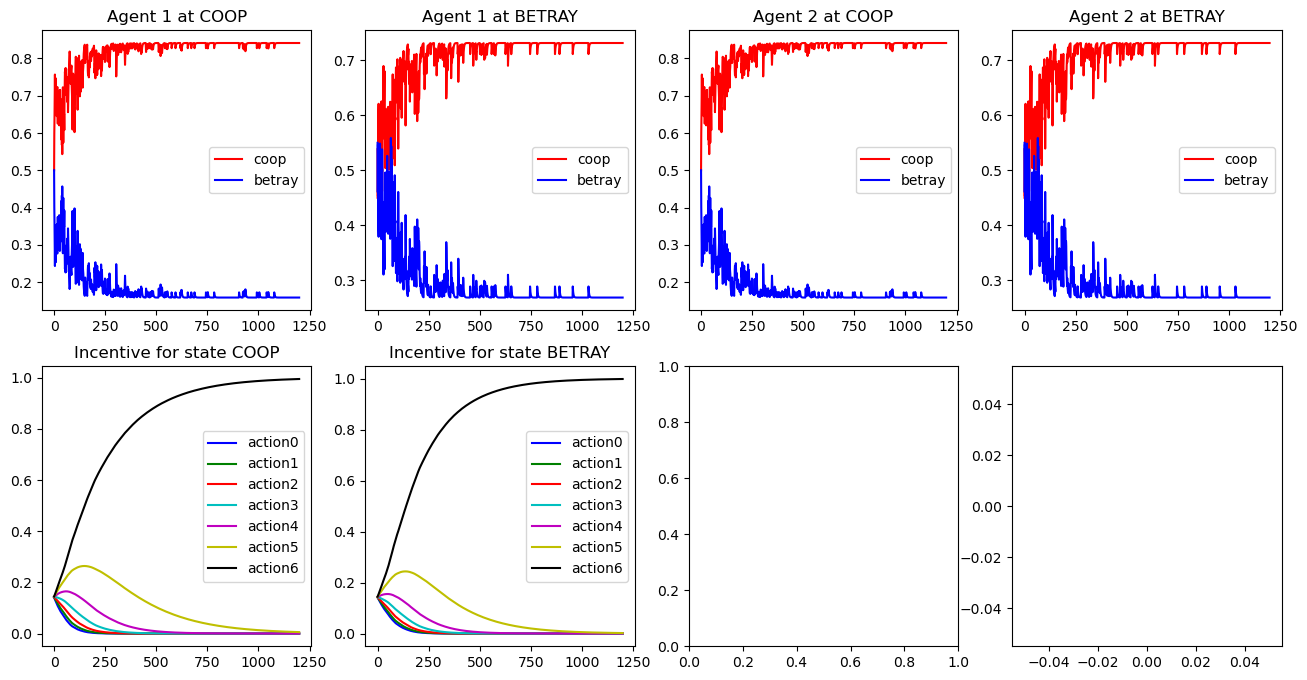

In [8]:
T = 1200
lr_a = 0.1
lr_i = 0.05
gamma = 0.9

a1 = np.array([[0.5,0.5],[0.5,0.5]])
a2 = np.array([[0.5,0.5],[0.5,0.5]])
ID_policy = np.ones([2, actions.shape[0]]) / actions.shape[0]   # uniform distribution

# Record trajector
a1_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
a2_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
incentive_traj = np.zeros([ T, 2, actions.shape[0] ])   # [n_iter, n_state, n_actions ]

for t in range(T):
    incentive = np.zeros([2,2,2]) # [n_state, n_agent, n_agent_actions]
    for s in [0,1]:
        # incentive_s = np.zeros([2,2])
        # for idx, a in enumerate(actions):
        #     incentive_s += ID_policy[s][idx] * a
        # incentive[s,0] = incentive_s[0]
        # incentive[s,1] = incentive_s[1]
        action_id = np.random.choice(a=actions.shape[0], size=1, p=ID_policy[s])
        incentive[s] = actions[action_id]

    # Update agents strategies and incentive policy
    for s in [0,1]:
        a1[s], a2[s] = update_strategies(s, a1[s], a2[s], incentive[s][0], incentive[s][1], lamda, lr_a)

    R_vec = np.zeros(2)
    for s in [0,1]:
        R_vec[s] = R0(s, a1[s], a2[s])
    P_mat = get_P_mat(a1, a2)
    V_vec = np.linalg.inv(np.eye(2) - gamma*P_mat) @ R_vec

    for s in [0,1]:
        Q_val = R_pre[s] + gamma * np.array([ P_pre[s] @ V_vec ])
        ID_policy_ = ID_policy[s] * np.exp( lr_i * Q_val )
        ID_policy[s] = normalize(ID_policy_)

    for s in [0,1]:
        a1_traj[t, s] = a1[s]
        a2_traj[t, s] = a2[s]
        incentive_traj[t, s] = ID_policy[s]

plot_mdp(T=T, a1_traj=a1_traj, a2_traj=a2_traj, incentive_traj=incentive_traj)

In [9]:
incentive_policy = incentive_traj[-1]
incentive_s = np.zeros([2, 2, 2])
for s in [0,1]:
    for idx, a in enumerate(actions):
        incentive_s[s] += incentive_policy[s][idx] * a
print("Final incentives are:\n at state 'COOP':\n {}\n at state 'BETRAY':\n {}".format(incentive_s[0], incentive_s[1]))

a1 = a1_traj[-1]
a2 = a2_traj[-1]
print("Final agents' strategies are: \n agent1:\n {}\n agent2:\n {}".format(a1, a2))

Final incentives are:
 at state 'COOP':
 [[5.99434977 0.        ]
 [5.99434977 0.        ]]
 at state 'BETRAY':
 [[5.9980407 0.       ]
 [5.9980407 0.       ]]
Final agents' strategies are: 
 agent1:
 [[0.8411309  0.1588691 ]
 [0.73105858 0.26894142]]
 agent2:
 [[0.8411309  0.1588691 ]
 [0.73105858 0.26894142]]


## Result for reward_type 1
The reward type=1 is 
$$
\begin{align}
\bar{R}_{\text{COOP}} (a^1_C, a^2_C) &= (a^1_C[\mathbf{c}] + a^2_C[\mathbf{c}])*2\\
\bar{R}_{\text{BETRAY}}(a^1_B, a^2_B) &= a^1_B[\mathbf{b}]+a^2_B[\mathbf{b}]
\end{align}
$$
The problem is slightly harder than previous one, since at state `BETRAY`, in the sense of immediate reward, the optimal action will be stay at `BETRAY`. However, only in a long run, move to state `COOP` can obtain more reward.  

The first stage calculated reward is:  

In [10]:
lamda = 2

def R1(s, a1, a2):
    assert s==0 or s==1, "The input s is {}, which is neighter 0 nor 1".format(s)
    if s==0: 
        reward = 2*(a1[0]+a2[0])    # COOP
    elif s==1: 
        reward = 1.5*(a1[1] + a2[1])       # BETRAY
    return reward

R_pre, P_pre = get_RP(R1, lamda=lamda, alpha=0.5)
print("Immediate reward for reward_type={} is\n {}".format(1, R_pre))
print("Transition is:\n {}".format(P_pre))

Immediate reward for reward_type=1 is
 [[1.51016268 2.         2.48983732 2.92423431 3.2702979  3.52318831
  3.69656728]
 [2.45272343 2.19317574 1.86737799 1.5        1.13262201 0.80682426
  0.54727657]]
Transition is:
 [[[0.14253696 0.85746304]
  [0.25       0.75      ]
  [0.38745562 0.61254438]
  [0.53444665 0.46555335]
  [0.66842802 0.33157198]
  [0.77580349 0.22419651]
  [0.8540381  0.1459619 ]]

 [[0.03327907 0.96672093]
  [0.07232949 0.92767051]
  [0.14253696 0.85746304]
  [0.25       0.75      ]
  [0.38745562 0.61254438]
  [0.53444665 0.46555335]
  [0.66842802 0.33157198]]]


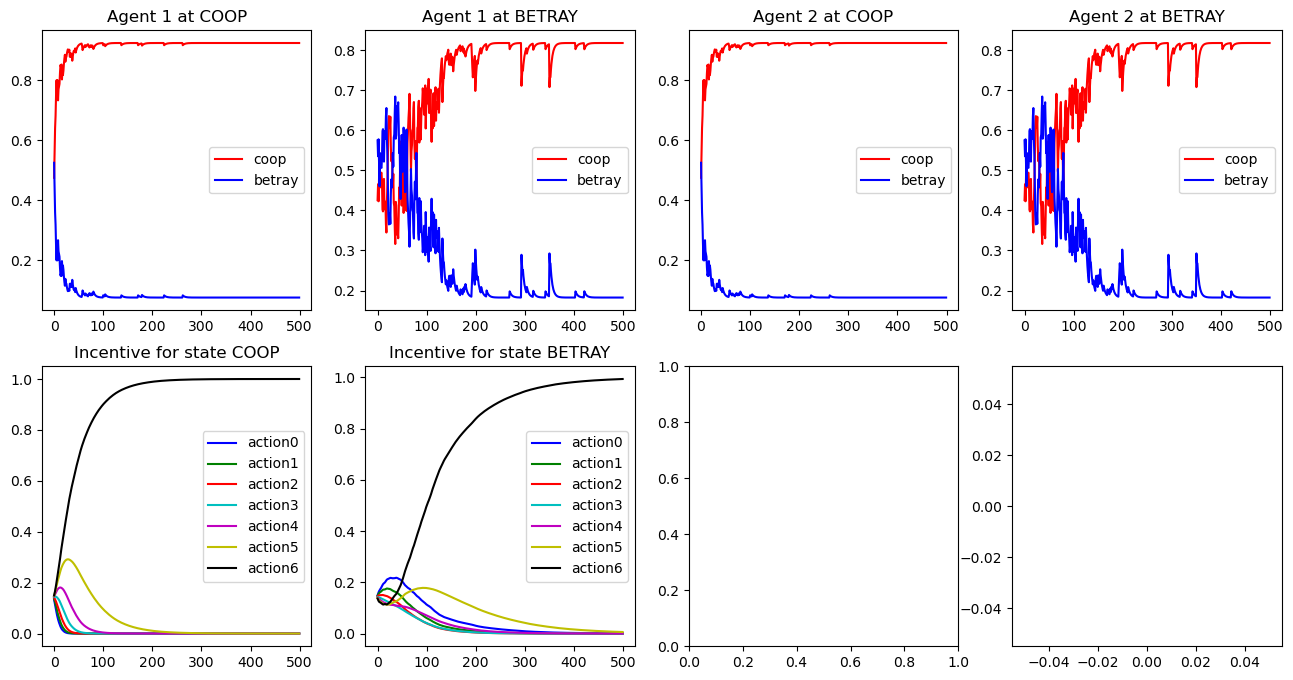

In [11]:
T = 500
lr_a = 0.1
lr_i = 0.05
gamma = 0.9

a1 = np.array([[0.5,0.5],[0.5,0.5]])
a2 = np.array([[0.5,0.5],[0.5,0.5]])
ID_policy = np.ones([2, actions.shape[0]]) / actions.shape[0]   # uniform distribution

# Record trajector
a1_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
a2_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
incentive_traj = np.zeros([ T, 2, actions.shape[0] ])   # [n_iter, n_state, n_actions ]

for t in range(T):
    incentive = np.zeros([2,2,2]) # [n_state, n_agent, n_agent_actions]
    for s in [0,1]:
        # incentive_s = np.zeros([2,2])
        # for idx, a in enumerate(actions):
        #     incentive_s += ID_policy[s][idx] * a
        # incentive[s,0] = incentive_s[0]
        # incentive[s,1] = incentive_s[1]
        action_id = np.random.choice(a=actions.shape[0], size=1, p=ID_policy[s])
        incentive[s] = actions[action_id]


    # Update agents strategies and incentive policy
    for s in [0,1]:
        a1[s], a2[s] = update_strategies(s, a1[s], a2[s], incentive[s][0], incentive[s][1], lamda, lr_a)

    R_vec = np.zeros(2)
    for s in [0,1]:
        R_vec[s] = R1(s, a1[s], a2[s])
    P_mat = get_P_mat(a1, a2)
    V_vec = np.linalg.inv(np.eye(2) - gamma*P_mat) @ R_vec

    for s in [0,1]:
        Q_val = R_pre[s] + gamma * np.array([ P_pre[s] @ V_vec ])
        ID_policy_ = ID_policy[s] * np.exp( lr_i * Q_val )
        ID_policy[s] = normalize(ID_policy_)

    for s in [0,1]:
        a1_traj[t, s] = a1[s]
        a2_traj[t, s] = a2[s]
        incentive_traj[t, s] = ID_policy[s]

plot_mdp(T=T, a1_traj=a1_traj, a2_traj=a2_traj, incentive_traj=incentive_traj)

In [12]:
incentive_policy = incentive_traj[-1]
incentive_s = np.zeros([2, 2, 2])
for s in [0,1]:
    for idx, a in enumerate(actions):
        incentive_s[s] += incentive_policy[s][idx] * a
print("Final incentives are:\n at state 'COOP': {}\n at state 'BETRAY': {}".format(incentive_s[0], incentive_s[1]))

a1 = a1_traj[-1]
a2 = a2_traj[-1]
print("Final agents' strategies are: \n agent1: {}\n agent2: {}".format(a1, a2))

Final incentives are:
 at state 'COOP': [[5.99998493 0.        ]
 [5.99998493 0.        ]]
 at state 'BETRAY': [[5.98968165 0.        ]
 [5.98968165 0.        ]]
Final agents' strategies are: 
 agent1: [[0.92414182 0.07585818]
 [0.81757448 0.18242552]]
 agent2: [[0.92414182 0.07585818]
 [0.81757448 0.18242552]]


## Result for reward_type 2
We then test for reward type=2:
$$
\begin{align}
\bar{R}_{\text{COOP}}(a^1_C, a^2_C) &= 2 - \left((a^1_C[\mathbf{c}]-0.8)^2 + (a^2_C[\mathbf{c}]-0.8)^2\right) \\
\bar{R}_\text{BETRAY} (a^1_B, a^2_B) &= 2 - \left((a^1_B[\mathbf{b}]-0.8)^2 + (a^2_B[\mathbf{b}]-0.8)^2\right)
\end{align}
$$ 
This reward type is harder than previous one since it requires agents' strategies to be at middle, rather than in two extreme.

In [13]:
lamda = 1

# def get_P_vec(a1_s, a2_s):
#     P = np.zeros(2)
#     P[0] = 0.5
#     P[1] = 1-P[0]
#     return P

# def get_P_mat(a1, a2):
#     P = np.zeros([2,2])
#     P[0] = get_P_vec(a1[0], a2[0])  # COOP -> [COOP, BETRAY]
#     P[1] = get_P_vec(a1[1], a2[1])  # BETRAY -> [COOP, BETRAY]
#     return P

# def get_RP(R, lamda=0.1, alpha=0.2, ):
#     R_pre = np.zeros([2, actions.shape[0]]) # reward (s,a)
#     P_pre = np.zeros([2, actions.shape[0], 2])  # (s,a) -> \Delta(2) i.e., [P(s'|s,a)]_{s'\in S}
#     initial_a = np.ones(2) / 2.0
#     for s in [0,1]:
#         for idx, a in enumerate(actions):
#             a1_traj, a2_traj = find_ne(s=s, a1=initial_a, a2=initial_a, i1=a[0], i2=a[1], lamda=lamda, alpha=alpha, T=50)
#             a1 = a1_traj[-1]
#             a2 = a2_traj[-1]
#             R_pre[s, idx] = R(s, a1, a2)
#             P_pre[s, idx] = get_P_vec(a1, a2)
#     return R_pre, P_pre

def R2(s, a1, a2):
    assert s==0 or s==1, "The input s is {}, which is neighter 0 nor 1".format(s)
    if s==0:
        reward = 2. - ((a1[0]-0.8)**2 + (a2[0]-0.8)**2)    # COOP
    elif s==1: 
        reward = 2. - ((a1[1]-0.8)**2 + (a2[1]-0.8)**2)    # BETRAY
    return reward

R_pre, P_pre = get_RP(R2, lamda=lamda, alpha=0.5)
print("Immediate reward for reward_type={} is:\n at state COOP\n {} \n at state BETRAY\n {}".format(2, R_pre[0], R_pre[1]))
print("Transition is: \n {}".format(P_pre))

Immediate reward for reward_type=2 is:
 at state COOP
 [1.43595357 1.82       1.99049416 1.98694366 1.95344227 1.93374196
 1.92526469] 
 at state BETRAY
 [1.95344227 1.98694366 1.99049416 1.82       1.43595357 1.07303068
 0.86726437]
Transition is: 
 [[[0.07232949 0.92767051]
  [0.25       0.75      ]
  [0.53444665 0.46555335]
  [0.77580349 0.22419651]
  [0.90739747 0.09260253]
  [0.96435108 0.03564892]
  [0.98665909 0.01334091]]

 [[0.00224921 0.99775079]
  [0.01420934 0.98579066]
  [0.07232949 0.92767051]
  [0.25       0.75      ]
  [0.53444665 0.46555335]
  [0.77580349 0.22419651]
  [0.90739747 0.09260253]]]


100%|██████████| 24000/24000 [00:02<00:00, 10267.99it/s]


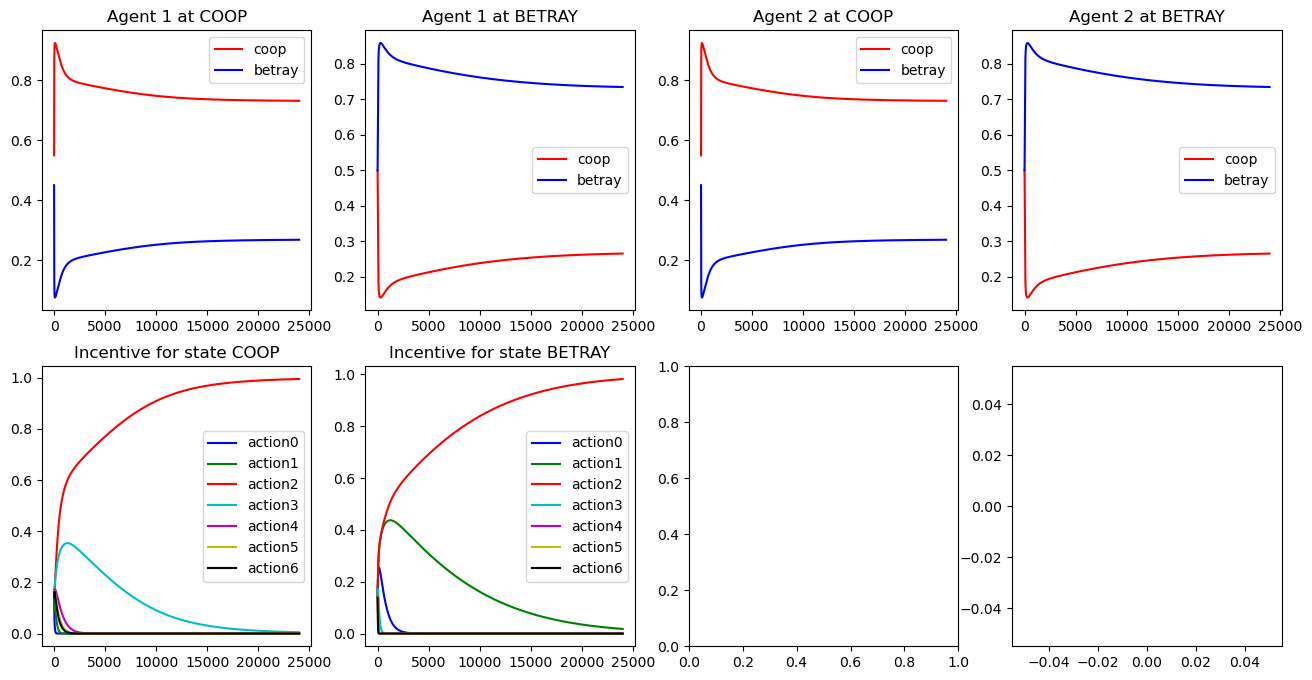

In [14]:
from tqdm import trange

T = 24000
lr_a = 0.1
lr_i = 0.05
gamma = 0.9

a1 = np.array([[0.5,0.5],[0.5,0.5]])
a2 = np.array([[0.5,0.5],[0.5,0.5]])
ID_policy = np.ones([2, actions.shape[0]]) / actions.shape[0]   # uniform distribution

# Record trajector
a1_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
a2_traj = np.zeros([T, 2, 2])   # [n_iter, n_state, n_actions]
incentive_traj = np.zeros([ T, 2, actions.shape[0] ])   # [n_iter, n_state, n_actions ]

for t in trange(T):
    incentive = np.zeros([2,2,2]) # [n_state, n_agent, n_agent_actions]
    for s in [0,1]:
        incentive_s = np.zeros([2,2])
        for idx, a in enumerate(actions):
            incentive_s += ID_policy[s][idx] * a
        incentive[s,0] = incentive_s[0]
        incentive[s,1] = incentive_s[1]
        # action_id = np.random.choice(a=actions.shape[0], size=1, p=ID_policy[s])
        # incentive[s] = actions[action_id]


    # Update agents strategies and incentive policy
    for s in [0,1]:
        a1[s], a2[s] = update_strategies(s, a1[s], a2[s], incentive[s][0], incentive[s][1], lamda, lr_a)

    R_vec = np.zeros(2)
    for s in [0,1]:
        R_vec[s] = R2(s, a1[s], a2[s])
    P_mat = get_P_mat(a1, a2)
    V_vec = np.linalg.inv(np.eye(2) - gamma*P_mat) @ R_vec

    for s in [0,1]:
        Q_val = R_pre[s] + np.array([ P_pre[s] @ V_vec ])
        ID_policy_ = ID_policy[s] * np.exp( lr_i * Q_val )
        ID_policy[s] = normalize(ID_policy_)

    for s in [0,1]:
        a1_traj[t, s] = a1[s]
        a2_traj[t, s] = a2[s]
        incentive_traj[t, s] = ID_policy[s]

plot_mdp(T=T, a1_traj=a1_traj, a2_traj=a2_traj, incentive_traj=incentive_traj)

In [15]:
incentive_policy = incentive_traj[-1]
incentive_s = np.zeros([2, 2, 2])
for s in [0,1]:
    for idx, a in enumerate(actions):
        incentive_s[s] += incentive_policy[s][idx] * a
print("Final incentives are:\n at state 'COOP': {}\n at state 'BETRAY': {}".format(incentive_s[0], incentive_s[1]))

a1 = a1_traj[-1]
a2 = a2_traj[-1]
print("Final agents' strategies are: \n agent1: {}\n agent2: {}".format(a1, a2))

Final incentives are:
 at state 'COOP': [[2.00502549 0.        ]
 [2.00502549 0.        ]]
 at state 'BETRAY': [[1.98224448 0.        ]
 [1.98224448 0.        ]]
Final agents' strategies are: 
 agent1: [[0.73204738 0.26795262]
 [0.2654589  0.7345411 ]]
 agent2: [[0.73204738 0.26795262]
 [0.2654589  0.7345411 ]]
